In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns
import numpy as np
from IPython.display import Audio
import os

In [2]:
# Define path to speech and song directories
speech_dir = "Audio_Speech_Actors_01-24"
song_dir = "Audio_Song_Actors_01-24"

# Mapping from emotion number to label
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

def extract_emotion_from_filename(filename):
    """Extracts emotion from RAVDESS filename."""
    parts = filename.split("-")
    emotion_code = parts[2]
    return emotion_map.get(emotion_code, "unknown")

def load_data(directory):
    """Loads RAVDESS wav files from a directory and returns a DataFrame with path and label."""
    data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                full_path = os.path.join(root, file)
                label = extract_emotion_from_filename(file)
                data.append({"path": full_path, "labels": label})
    return pd.DataFrame(data)

# Load speech and song data
df_speech = load_data(speech_dir)
df_song = load_data(song_dir)

# Combine into one DataFrame
df_combined = pd.concat([df_speech, df_song], ignore_index=True)

# Shuffle (optional)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

# View sample
print(df_combined)

                                                   path     labels
0     Audio_Song_Actors_01-24\Actor_03\03-02-01-01-0...    neutral
1     Audio_Speech_Actors_01-24\Actor_24\03-01-07-01...    disgust
2     Audio_Song_Actors_01-24\Actor_02\03-02-04-02-0...        sad
3     Audio_Speech_Actors_01-24\Actor_17\03-01-02-01...       calm
4     Audio_Speech_Actors_01-24\Actor_21\03-01-08-02...  surprised
...                                                 ...        ...
2447  Audio_Speech_Actors_01-24\Actor_05\03-01-04-02...        sad
2448  Audio_Speech_Actors_01-24\Actor_17\03-01-04-02...        sad
2449  Audio_Speech_Actors_01-24\Actor_15\03-01-06-01...    fearful
2450  Audio_Song_Actors_01-24\Actor_05\03-02-03-02-0...      happy
2451  Audio_Speech_Actors_01-24\Actor_14\03-01-03-02...      happy

[2452 rows x 2 columns]


In [3]:
df_combined['labels'].value_counts()

labels
calm         376
sad          376
happy        376
angry        376
fearful      376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='labels'>

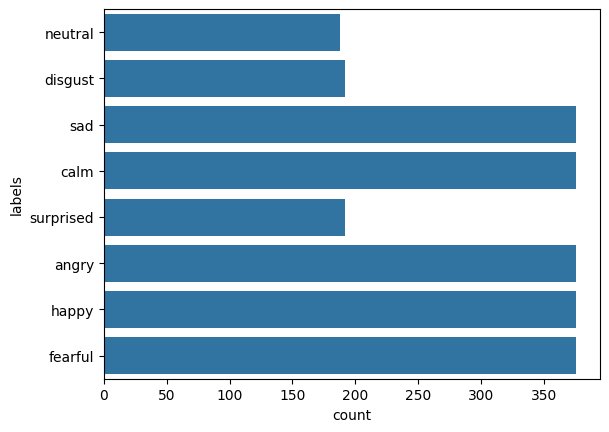

In [4]:
sns.countplot(df_combined['labels'])

In [5]:
import librosa
import numpy as np

def compute_log_mel_spect(y, sr, n_mels=128, hop_length=512, n_fft=2048, max_len=100):
    # Compute Mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                         hop_length=hop_length, n_fft=n_fft)
    
    # Convert to log scale
    log_mel = librosa.power_to_db(mel, ref=np.max)
    
    # Pad or trim to fixed length
    if log_mel.shape[1] < max_len:
        pad_width = max_len - log_mel.shape[1]
        log_mel = np.pad(log_mel, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        log_mel = log_mel[:, :max_len]

    # Normalize
    log_mel = (log_mel - np.mean(log_mel)) / (np.std(log_mel) + 1e-9)

    return log_mel


In [6]:
def plot_mel_spect(log_mel, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_mel, sr=sr, hop_length=512, 
                                 x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-Mel Spectrogram')
    plt.tight_layout()
    plt.show()

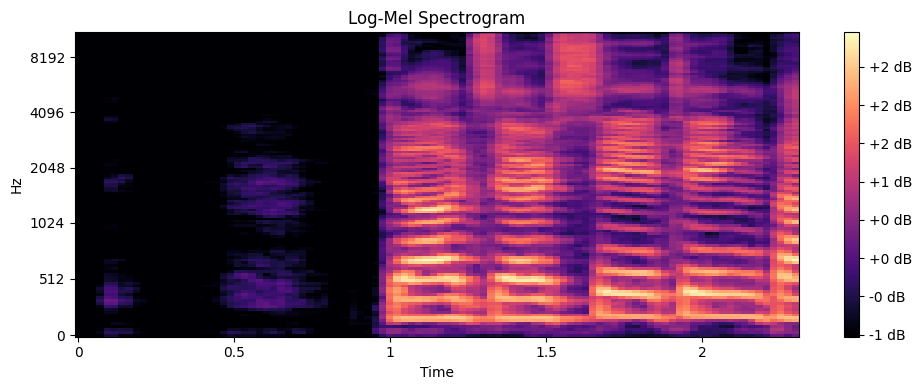

In [7]:
path = df_combined.iloc[0]['path']
data, sr = librosa.load(path)
log_mel = compute_log_mel_spect(data, sr)
plot_mel_spect(log_mel, sr)


In [8]:
features = []

for _, row in df_combined.iterrows():
    path = row['path']
    data, sr = librosa.load(path, sr=16000)
    log_spect = compute_log_mel_spect(data, sr)
    log_spect = np.expand_dims(log_spect, axis=-1)
    features.append(log_spect)

X = np.array(features)


In [9]:
X

array([[[[-1.2783031e+00],
         [-1.2783031e+00],
         [-1.2783031e+00],
         ...,
         [-1.2783031e+00],
         [-1.2783031e+00],
         [-1.2783031e+00]],

        [[-1.2783031e+00],
         [-1.2783031e+00],
         [-1.0461022e+00],
         ...,
         [-9.7108990e-01],
         [-1.1936758e+00],
         [-1.2459208e+00]],

        [[-1.2783031e+00],
         [-1.2783031e+00],
         [-1.1204824e+00],
         ...,
         [-4.7692478e-01],
         [-8.2073855e-01],
         [-7.7083206e-01]],

        ...,

        [[-1.2783031e+00],
         [-1.2783031e+00],
         [-1.2783031e+00],
         ...,
         [-9.1813457e-01],
         [-8.4738517e-01],
         [-8.2152712e-01]],

        [[-1.2783031e+00],
         [-1.2783031e+00],
         [-1.2783031e+00],
         ...,
         [-1.0253432e+00],
         [-9.7817671e-01],
         [-8.6304229e-01]],

        [[-1.2783031e+00],
         [-1.2783031e+00],
         [-1.2783031e+00],
         ...,
 

In [18]:
X = np.squeeze(X)
X = np.expand_dims(X, -1)  # to ensure shape becomes (2452, 128, 100, 1)
print(X.shape)

(2452, 128, 100, 1)


In [14]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
y=enc.fit_transform(df_combined[['labels']])

In [15]:
y=y.toarray()

In [16]:
y.shape

(2452, 8)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,GRU, Bidirectional
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [19]:
# 1. Encode string labels to integers
raw_y = df_combined['labels'].values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(raw_y)  # e.g., ['happy', 'sad'] → [1, 2]

# 2. Convert to one-hot for categorical_crossentropy loss
y_categorical = to_categorical(y_encoded)  # Shape: (samples, num_classes)

# 3. Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_categorical, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [20]:
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical

# Flatten to 2D for oversampling: (samples, features)
# We’ll keep only time dimension: (samples, n_mels * time_steps)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # shape: (num_samples, 128 * 100)

# Use RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled_flat, y_train_encoded_resampled = ros.fit_resample(X_train_flat, y_train_encoded)

# One-hot encode again for model training
y_train_resampled = to_categorical(y_train_encoded_resampled, num_classes=len(label_encoder.classes_))

# Reshape X_train back to original 4D shape: (samples, 128, 100, 1)
X_train_resampled = X_train_resampled_flat.reshape(-1, 128, 100, 1)

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import LSTM, Dense, Dropout, Reshape, Permute
from keras.optimizers import Adam

def create_crnn_model(input_shape=(128, 100, 1), num_classes=8):
    model = Sequential()

    # ----- CNN Block -----
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))  # (64, 50, 32)

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))  # (32, 25, 64)

    # ----- Reshape for RNN -----
    model.add(Permute((2, 1, 3)))  # (time_steps, freq, channels)
    model.add(Reshape((25, 32 * 64)))  # (time_steps=25, features=2048)

    # ----- RNN Block -----
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))

    # ----- Output -----
    model.add(Dense(num_classes, activation='softmax'))

    # ----- Compile -----
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


c:\Users\vy885\OneDrive - iitr.ac.in\Desktop\openPro\speechEmotionClassification\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 100, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_1 (Permute)             │ (None, 25, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 25, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 25, 128)        │     1,114,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,183,752 (4.52 MB)

 Trainable params: 1,183,560 (4.51 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.2143 - loss: 1.9864 - val_accuracy: 0.2403 - val_loss: 2.0272
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.4659 - loss: 1.6045 - val_accuracy: 0.2240 - val_loss: 2.0019
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - accuracy: 0.6225 - loss: 1.2879 - val_accuracy: 0.3523 - val_loss: 1.9015
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.6828 - loss: 1.0337 - val_accuracy: 0.4236 - val_loss: 1.6362
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.7695 - loss: 0.8146 - val_accuracy: 0.5560 - val_loss: 1.2837
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.8120 - loss: 0.6610 - val_accuracy: 0.6354 - val_loss: 1.0401
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.8436 - loss: 0.5345 - val_accuracy: 0.6802 - val_loss: 0.8838
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.8998 - loss: 0.3806 - 

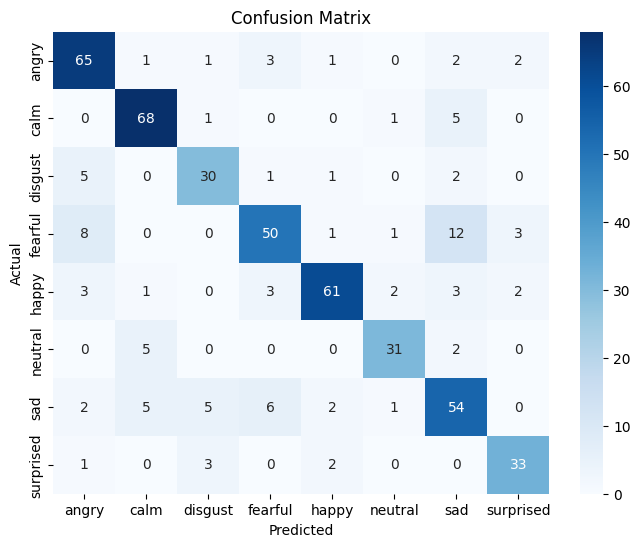

In [23]:
model = create_crnn_model(input_shape=(128, 100, 1), num_classes=y_train.shape[1])
model.summary()

history=model.fit(X_train_resampled, y_train_resampled,
          validation_data=(X_test, y_test),
          epochs=100, batch_size=32)

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
model.save("crnn_model.h5")  # HDF5 format

In [25]:
from keras.models import load_model

model = load_model("crnn_model.h5")


In [ ]:
import librosa
import numpy as np

# Load audio and extract log-Mel spectrogram
data, sr = librosa.load("test_audio.wav", sr=16000)
log_spec = compute_log_mel_spect(data, sr)  # Your function from before
log_spec = np.expand_dims(log_spec, axis=-1)  # (128, 100, 1)
log_spec = np.expand_dims(log_spec, axis=0)  # (1, 128, 100, 1)

# Predict
prediction = model.predict(log_spec)  # shape: (1, num_classes)
predicted_class = np.argmax(prediction)

# Decode class label
label = label_encoder.inverse_transform([predicted_class])[0]
print("Predicted Emotion:", label)
